<a href="https://colab.research.google.com/github/Anldrnz/Physics-Informed-NN-ODE-PDE-solutions/blob/main/mass_spring_damper_PINN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem

Mass spring damper system

- input: t
- output: u
- No external force
- Changing mass

### ***Single input of time not working well, moving on to version 2***

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import numpy as np


In [236]:
# We consider Net as our solution u_theta(x,t)

"""
When forming the network, we have to keep in mind the number of inputs and outputs
In ur case: #inputs = 2 (x,t)
and #outputs = 1

You can add ass many hidden layers as you want with as many neurons.
More complex the network, the more prepared it is to find complex solutions, but it also requires more data.

Let us create this network:
min 5 hidden layer with 5 neurons each.
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(1,20)
        self.hidden_layer2 = nn.Linear(20,20)
        self.output_layer = nn.Linear(20,1)

    def forward(self, t):
        input = t
        layer1_out = torch.tanh(self.hidden_layer1(input))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        output = self.output_layer(layer2_out) ## For regression, no activation is used in output layer
        return output

In [237]:
### (2) Model
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

In [216]:
import math

dt = 0.05 # ΔT (sampling period) seconds
# Initial values
position = 0
velocity = 0
acceleration = 0

# Constants
mass = 1 # mass
k = 0.8 # spring coefficient
b = 0.2 # damping coefficient
external_force = 2

# Callback Function
def f_real():
    global dt, position, velocity, acceleration, mass, k, b # Get global variables

    spring_force = k * position # Fs = k * x
    damper_force = b * velocity # Fb = b * x'

    # If we leave the acceleration alone in equation
    # acceleration = - ((b * velocity) + (k * position)) / mass
    acceleration = - (external_force + spring_force + damper_force) / mass
    velocity += (acceleration * dt) # Integral(a) = v
    position += (velocity * dt) # Integral(v) = x
    mass -= 0.0015*math.sin(2*math.pi*dt) + 0.005*dt

    return (position) # Return position

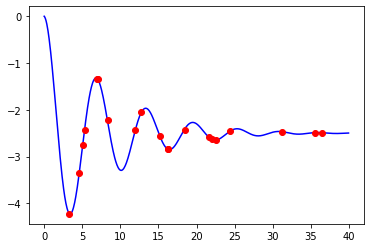

In [217]:
import matplotlib.pyplot as plt
from random import sample

position = 0
velocity = 0
acceleration = 0

# Constants
mass = 1 # mass
k = 0.8 # spring coefficient
b = 0.2 # damping coefficient
external_force = 2

# create data
t = np.arange(0,40,0.05)
train_data_count = 20

pos_real = np.array([])
for i in range(len(t)):
  pos_real = np.append(pos_real, f_real())

# plot lines
plt.plot(t, pos_real, label = "Analytical Solution", color="blue")

# get random input data
t_sample = np.random.choice(t,train_data_count)
x_sample_idx = np.zeros(len(t_sample))
for i in range(len(t_sample)):
  x_sample_idx[i] = int(t_sample[i]/0.05)
x_sample = pos_real[x_sample_idx.astype(int)]
plt.plot(t_sample, x_sample, 'o', color="red")

In [218]:
# Constants
mass = 1 # mass
k = 0.8 # spring coefficient
b = 0.2 # damping coefficient
external_force = 2

def f(t, net):
    u = net(t) # the dependent variable u is given by the network based on independent variables t
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0] # Velocity
    u_tt = torch.autograd.grad(u_t.sum(), t, create_graph=True)[0] # Acceleration
    eqn = (mass*u_tt + b*u_t + k*u + external_force)
    return eqn

In [244]:
### (3) Training

iterations = 10000
for epoch in range(iterations):
#epoch = 0
#loss = torch.from_numpy(np.array([1]))
#while loss.data > 0.0005:
    #epoch += 1
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on observed data
    t_data = Variable(torch.from_numpy(t_sample).float(), requires_grad=False).to(device)
    x_data = Variable(torch.from_numpy(x_sample).float(), requires_grad=False).to(device)
    net_x_out = net(t_data.reshape(len(t_data),1)) # output of u(t)

    mse_u = mse_cost_function(net_x_out, x_data.reshape(len(x_data),1))
    
    # Loss based on ODE
    t_collocation = np.random.uniform(low=0.0, high=40.0, size=(800,1))
    all_zeros = np.zeros((800,1))
    
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_t_collocation.reshape(len(pt_t_collocation),1), net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros.reshape(len(pt_all_zeros),1))
    
    # Combining the loss functions
    loss = mse_u + mse_f
    
    loss.backward()
    optimizer.step()

    with torch.autograd.no_grad():
      if epoch % 500 == 0:
        print(epoch,"Traning Loss:",loss.data,"mse_u:",mse_u,"mse_f",mse_f)


0 Traning Loss: tensor(0.3283) mse_u: tensor(0.3283, grad_fn=<MseLossBackward0>) mse_f tensor(1.2274e-05, grad_fn=<MseLossBackward0>)
500 Traning Loss: tensor(0.0084) mse_u: tensor(0.0053, grad_fn=<MseLossBackward0>) mse_f tensor(0.0031, grad_fn=<MseLossBackward0>)
1000 Traning Loss: tensor(0.0075) mse_u: tensor(0.0045, grad_fn=<MseLossBackward0>) mse_f tensor(0.0031, grad_fn=<MseLossBackward0>)
1500 Traning Loss: tensor(0.0065) mse_u: tensor(0.0038, grad_fn=<MseLossBackward0>) mse_f tensor(0.0027, grad_fn=<MseLossBackward0>)
2000 Traning Loss: tensor(0.0063) mse_u: tensor(0.0033, grad_fn=<MseLossBackward0>) mse_f tensor(0.0030, grad_fn=<MseLossBackward0>)
2500 Traning Loss: tensor(0.0059) mse_u: tensor(0.0031, grad_fn=<MseLossBackward0>) mse_f tensor(0.0028, grad_fn=<MseLossBackward0>)
3000 Traning Loss: tensor(0.0056) mse_u: tensor(0.0031, grad_fn=<MseLossBackward0>) mse_f tensor(0.0024, grad_fn=<MseLossBackward0>)
3500 Traning Loss: tensor(0.0057) mse_u: tensor(0.0029, grad_fn=<MseL

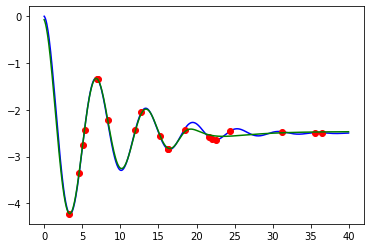

In [245]:
import matplotlib.pyplot as plt
from random import sample

t = np.arange(0,40,0.05)

# plot lines
plt.plot(t, pos_real, label = "Analytical Solution", color="blue")

# get random input data
plt.plot(t_sample, x_sample, 'o', color="red")

pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
out = net(pt_t.reshape(len(pt_t),1))
out=out.data.cpu().numpy()
plt.plot(t, out, label = "NN Solution", color="green")

In [ ]:
# Save Model
torch.save(net.state_dict(), "model_uxt.pt")